### Importing the libraries

In [92]:
import pandas as pd
import numpy as np
import concurrent.futures
import torch
import cv2
import random
import matplotlib.pyplot as plt
from PIL import ImageFile,Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

### Creating the dataframe

In [93]:
data1 = pd.read_csv('/media/hdd2/navaneeth/Deep-Learning-Projects/pytorch/color/color_bags.csv')
data2 = pd.read_csv('/media/hdd2/navaneeth/Deep-Learning-Projects/pytorch/color/color_tops.csv')
data3 = pd.read_csv('/media/hdd2/navaneeth/Deep-Learning-Projects/pytorch/color/color_pants.csv')

In [94]:
data = pd.concat([data1,data2,data3],ignore_index=True)
data = data[data['Category'].isin(['Bags','Pants','Tops'])]

### Downloading the images from URL and saving

In [95]:
""" import requests

def download_image(url, file_name):
    r = requests.get(url, stream=True)
    if r.status_code == 200:
        print('Downloading ' + file_name)
        r.raw.decode_content = True
        with open(file_name, 'wb') as f:
            f.write(r.content)
        return file_name
    else:
        return None

with concurrent.futures.ThreadPoolExecutor() as executor:
    for i, row in data.iterrows():
        file_name = 'images/' + str(i) + '.jpg'
        url = row['image_url']
        executor.submit(download_image, url, file_name) """

" import requests\n\ndef download_image(url, file_name):\n    r = requests.get(url, stream=True)\n    if r.status_code == 200:\n        print('Downloading ' + file_name)\n        r.raw.decode_content = True\n        with open(file_name, 'wb') as f:\n            f.write(r.content)\n        return file_name\n    else:\n        return None\n\nwith concurrent.futures.ThreadPoolExecutor() as executor:\n    for i, row in data.iterrows():\n        file_name = 'images/' + str(i) + '.jpg'\n        url = row['image_url']\n        executor.submit(download_image, url, file_name) "

### Removing Unnecessary data from each dataset

In [96]:
data.drop(['image_url'], axis=1, inplace=True)
data.drop(['Category'], axis=1, inplace=True)

### Adding image data to the dataframes

In [97]:
def preprocess_image(file):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

with concurrent.futures.ThreadPoolExecutor() as executor:
    for i, row in data.iterrows():
        file_name = 'images/' + str(i) + '.jpg'
        data.at[i, 'image_data'] = executor.submit(
            preprocess_image, file_name)

data['image_data'] = data['image_data'].apply(lambda x: x.result())

In [98]:
print(data.head())

  Color Hex Base Color                                         image_data
0   #87A8C6       Blue  [[[194, 189, 185], [194, 189, 185], [194, 189,...
1   #3D2E23      Brown  [[[173, 148, 117], [176, 151, 120], [179, 154,...
2   #B11821        Red  [[[124, 63, 44], [142, 81, 62], [138, 80, 60],...
3   #C0B1AF    Neutral  [[[250, 250, 250], [248, 248, 248], [252, 252,...
4   #6E9AB6       Blue  [[[213, 186, 143], [208, 181, 138], [215, 188,...


### Plotting sample images of each dataset

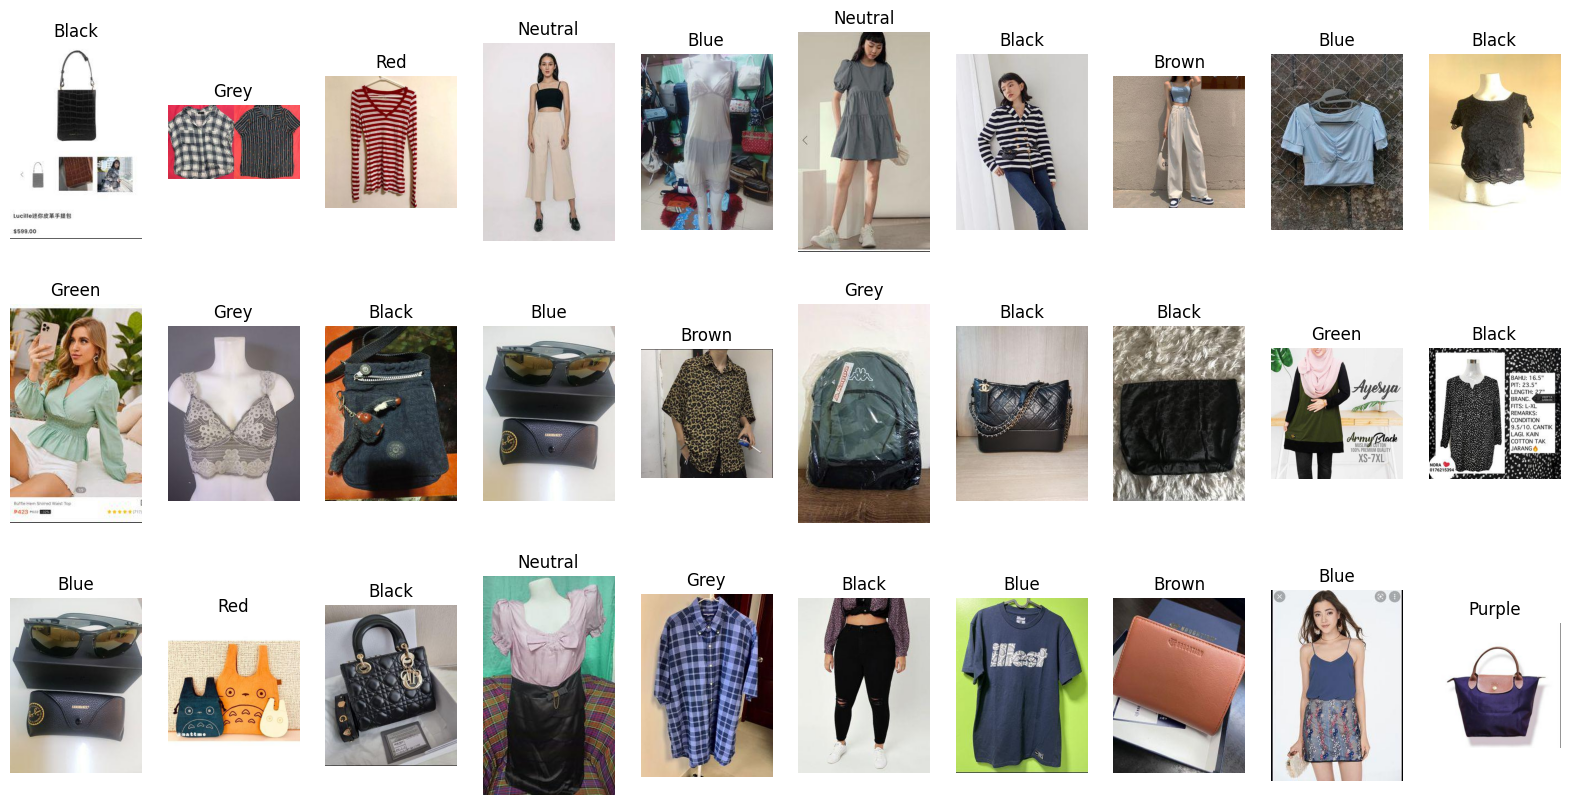

In [99]:
random.seed(31)
fig, ax = plt.subplots(3, 10, figsize=(20, 10))
for i in range(10):
    x = random.randint(0, len(data))
    y = random.randint(0, len(data))
    z = random.randint(0, len(data))
    img1=data.iloc[x]['image_data']
    img2=data.iloc[y]['image_data']
    img3=data.iloc[z]['image_data']
    ax[0, i].imshow(img1)
    ax[0, i].set_title(data.iloc[x]['Base Color'])
    ax[1, i].imshow(img2)
    ax[1, i].set_title(data.iloc[y]['Base Color'])
    ax[2, i].imshow(img3)
    ax[2, i].set_title(data.iloc[z]['Base Color'])
    ax[0, i].axis('off')
    ax[1, i].axis('off')
    ax[2, i].axis('off')
plt.show()

### Image Processing 

#### Removing all unnecessary colors other than the Color HEX given in data

In [100]:
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

def keep_color(image, hex_color):
    rgb_color = hex_to_rgb(hex_color)
    lower_bound=np.array([rgb_color[0]-30,rgb_color[1]-30,rgb_color[2]-30])
    upper_bound=np.array([rgb_color[0]+20,rgb_color[1]+20,rgb_color[2]+20])
    mask = cv2.inRange(image, lower_bound, upper_bound)
    image[mask==0] = [255,255,255]
    return image

def remove(img):
    gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    contours = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[0]
    max_contour = max(contours, key=cv2.contourArea)
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask, [max_contour], 0, 255, -1)
    result = img.copy()
    result[mask==0] = (255,255,255)
    return result

In [101]:
for i, row in data.iterrows():
    image = row['image_data']
    image = keep_color(image, row['Color Hex'])
    #image = remove(image)
    data.at[i, 'image_data'] = image

### Plotting the processed images

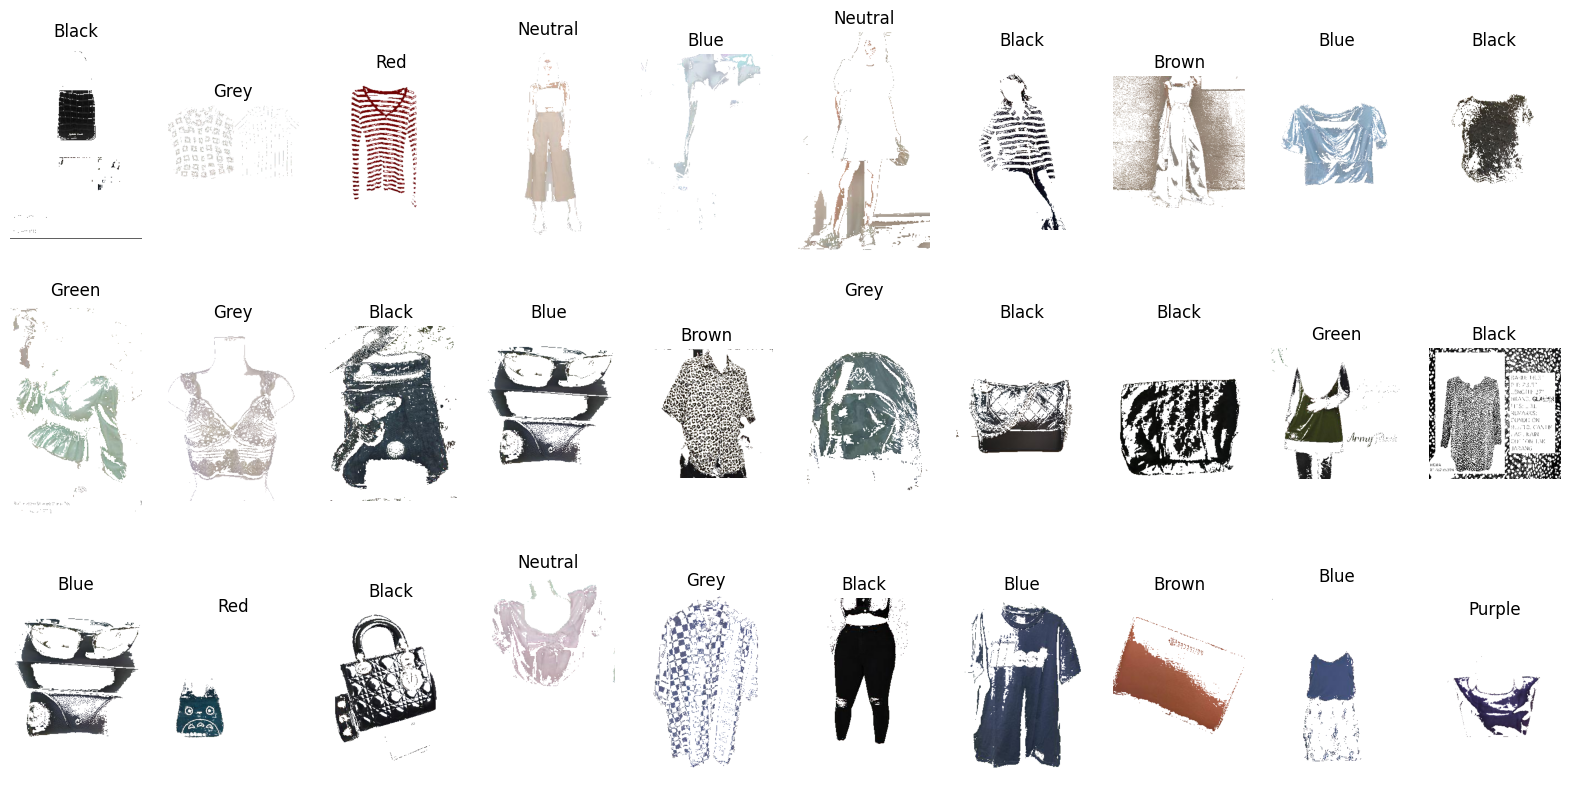

In [102]:
random.seed(31)
fig, ax = plt.subplots(3, 10, figsize=(20, 10))
for i in range(10):
    x = random.randint(0, len(data))
    y = random.randint(0, len(data))
    z = random.randint(0, len(data))
    img1=data.iloc[x]['image_data']
    img2=data.iloc[y]['image_data']
    img3=data.iloc[z]['image_data']
    ax[0, i].imshow(img1)
    ax[0, i].set_title(data.iloc[x]['Base Color'])
    ax[1, i].imshow(img2)
    ax[1, i].set_title(data.iloc[y]['Base Color'])
    ax[2, i].imshow(img3)
    ax[2, i].set_title(data.iloc[z]['Base Color'])
    ax[0, i].axis('off')
    ax[1, i].axis('off')
    ax[2, i].axis('off')
plt.show()

### Splitting the dataset into train,validation and testsets (70%-15%-15%)

In [103]:
from sklearn.model_selection import train_test_split

train_data, temp_data = train_test_split(data, test_size=0.3, random_state=31)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=31)

print(train_data.shape) 
print(val_data.shape)
print(test_data.shape)

print(train_data['Base Color'].value_counts())


(2844, 3)
(609, 3)
(610, 3)
Base Color
Black      627
Grey       511
Blue       410
Brown      359
Neutral    280
Green      155
Red        142
Pink       121
White      113
Purple      70
Yellow      30
Orange      26
Name: count, dtype: int64


### Upsampling miniority classes to match with the majority class

In [104]:
from sklearn.utils import resample

max_samples = max(train_data['Base Color'].value_counts())
train_data = train_data.groupby(['Base Color'])
train_data = train_data.apply(
    lambda x: resample(x, replace=True, n_samples=max_samples, random_state=31))
train_data.reset_index(drop=True, inplace=True)
print(train_data['Base Color'].value_counts())


Base Color
Black      627
Blue       627
Brown      627
Green      627
Grey       627
Neutral    627
Orange     627
Pink       627
Purple     627
Red        627
White      627
Yellow     627
Name: count, dtype: int64


In [106]:
color_dict = {}
for i, c in enumerate(set(data['Base Color'].unique())):
    color_dict[c] = i
print(color_dict)

{'Pink': 0, 'Green': 1, 'Blue': 2, 'White': 3, 'Yellow': 4, 'Brown': 5, 'Neutral': 6, 'Black': 7, 'Grey': 8, 'Red': 9, 'Purple': 10, 'Orange': 11}


### The Color Dataset

In [107]:
from torch.utils.data import Dataset, DataLoader

class ColorDataset(Dataset):
    def __init__(self, data,colors, transform=None):
        self.data = data
        self.transform = transform
        self.color2idx = colors

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data.iloc[idx]['image_data']
        img = Image.fromarray(img)
        img = self.transform(img)
        label = self.data.iloc[idx]['Base Color']
        label = self.color2idx[label]
        return img, label

### Creating the dataloaders

In [108]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.9, 1.2)),
    transforms.ColorJitter(brightness=0.5),
    transforms.ToTensor(),
])

transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.9, 1.2)),
    transforms.ToTensor(),
])

train_dataset = ColorDataset(train_data,color_dict, transform=train_transform)
valid_dataset = ColorDataset(val_data,color_dict, transform=transform)
test_dataset = ColorDataset(test_data,color_dict, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=3)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=3)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=3)

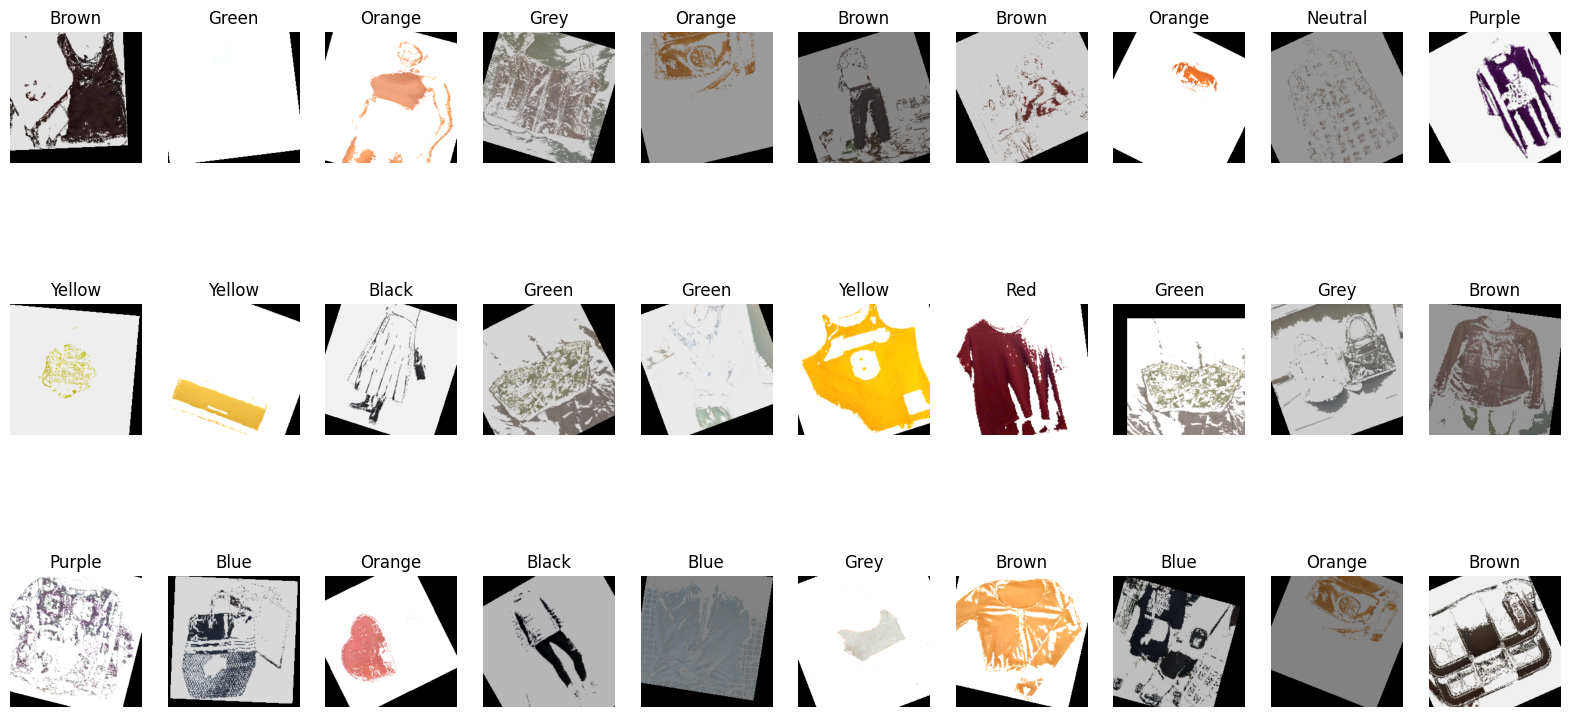

In [109]:
fig, ax = plt.subplots(3, 10, figsize=(20, 10))
for i, (img, label) in enumerate(train_loader):
    if i >= 3:
        break
    for j in range(10):
        ax[i, j].imshow(img[j].permute(1, 2, 0))
        ax[i, j].set_title(list(color_dict.keys())[list(color_dict.values()).index(label[j].item())])
        ax[i, j].axis('off')
plt.show()

### Model Creation , Loss Function and Optimizers

In [110]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

class ColorClassifier(nn.Module):
    def __init__(self):
        super(ColorClassifier, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, len(color_dict)),
        )

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

    
model = ColorClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)

In [111]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)

CrossEntropyLoss()

### Prediction for a single image by Untrained model

In [112]:
images,labels=next(iter(test_loader))
images,labels=images.to(device),labels.to(device)
output=model(images)
print(output[0])
_, preds = torch.max(output, 1)
print("Actual:", labels[0])

tensor([ 0.0158,  0.0167,  0.0249, -0.0061,  0.0185, -0.0022, -0.0187,  0.0243,
        -0.0014,  0.0120,  0.0109,  0.0308], device='cuda:0',
       grad_fn=<SelectBackward0>)
Actual: tensor(6, device='cuda:0')


In [113]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

### Training Loop

In [114]:
import mlflow
epochs = 32
valid_loss_min = np.Inf
train_losses=[]
valid_losses=[]
train_accs=[]
valid_accs=[]
mlflow.set_experiment("Color_Classifier")
#mlflow.end_run()
with mlflow.start_run() as run:
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("Learning Rate", 0.001)
    mlflow.log_param("scheduler", "ReduceLROnPlateau")
    mlflow.log_param("Optimizer", "Adam")
    mlflow.log_param("Loss Function", "CrossEntropyLoss")
    mlflow.log_param("Batch Size", 32)
    #mlflow.log_param("Dropout", 0.25)
    mlflow.log_param("Activation", "ReLU")
    mlflow.log_param("Layers", "5 Convolutional, 3 Fully Connected")
    for epoch in range(epochs):
        train_loss = 0
        valid_loss = 0
        train_acc = 0
        valid_acc = 0
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*images.size(0)
            _, preds = torch.max(output, 1)
            train_acc += torch.sum(preds == labels.data)
        model.eval()
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            valid_loss += loss.item()*images.size(0)
            _, preds = torch.max(output, 1)
            valid_acc += torch.sum(preds == labels.data)
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(valid_loader.dataset)
        train_acc = train_acc/len(train_loader.dataset)*100
        valid_acc = valid_acc/len(valid_loader.dataset)*100
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accs.append(train_acc.item())
        valid_accs.append(valid_acc.item())
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
            epoch+1, train_loss, valid_loss, train_acc, valid_acc))
        
        mlflow.log_metric("train_loss", train_loss)
        mlflow.log_metric("valid_loss", valid_loss)
        mlflow.log_metric("train_acc", train_acc)
        mlflow.log_metric("valid_acc", valid_acc)

        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/valid', valid_loss, epoch)
        writer.add_scalar('Accuracy/train', train_acc, epoch)
        writer.add_scalar('Accuracy/valid', valid_acc, epoch)
        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model...'.format(
                valid_loss_min, valid_loss))
            torch.save(model.state_dict(), 'model1.pt')
            valid_loss_min = valid_loss
        scheduler.step(valid_loss)
    mlflow.pytorch.log_model(model, "model1")
    current_run_id = mlflow.active_run().info.run_id

Epoch: 1 	Training Loss: 2.485876 	Validation Loss: 2.480811 	Training Accuracy: 7.881446 	Validation Accuracy: 16.748768
Validation loss decreased (inf --> 2.480811). Saving model...
Epoch: 2 	Training Loss: 2.470283 	Validation Loss: 2.365455 	Training Accuracy: 9.835194 	Validation Accuracy: 18.226601
Validation loss decreased (2.480811 --> 2.365455). Saving model...
Epoch: 3 	Training Loss: 2.218418 	Validation Loss: 2.184782 	Training Accuracy: 16.480595 	Validation Accuracy: 28.243021
Validation loss decreased (2.365455 --> 2.184782). Saving model...
Epoch: 4 	Training Loss: 2.084613 	Validation Loss: 1.871037 	Training Accuracy: 19.231792 	Validation Accuracy: 24.794746
Validation loss decreased (2.184782 --> 1.871037). Saving model...
Epoch: 5 	Training Loss: 2.013933 	Validation Loss: 2.066183 	Training Accuracy: 23.325357 	Validation Accuracy: 32.348110
Epoch: 6 	Training Loss: 1.940244 	Validation Loss: 1.730449 	Training Accuracy: 26.368952 	Validation Accuracy: 34.646961
V

2023/10/11 14:01:00 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Epoch: 32 	Training Loss: 0.381192 	Validation Loss: 0.778878 	Training Accuracy: 86.682610 	Validation Accuracy: 74.876846


2023/10/11 14:01:04 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


### Test Accuracy

In [124]:
model.load_state_dict(torch.load('model1.pt'))

with mlflow.start_run(run_id=current_run_id):
    model.eval()
    test_acc = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        _, preds = torch.max(output, 1)
        test_acc += torch.sum(preds == labels.data)
    test_acc = test_acc/len(test_loader.dataset)*100
    mlflow.log_metric("test_acc", test_acc)
    print("Test Accuracy: {:.6f}".format(test_acc))

Test Accuracy: 74.426231


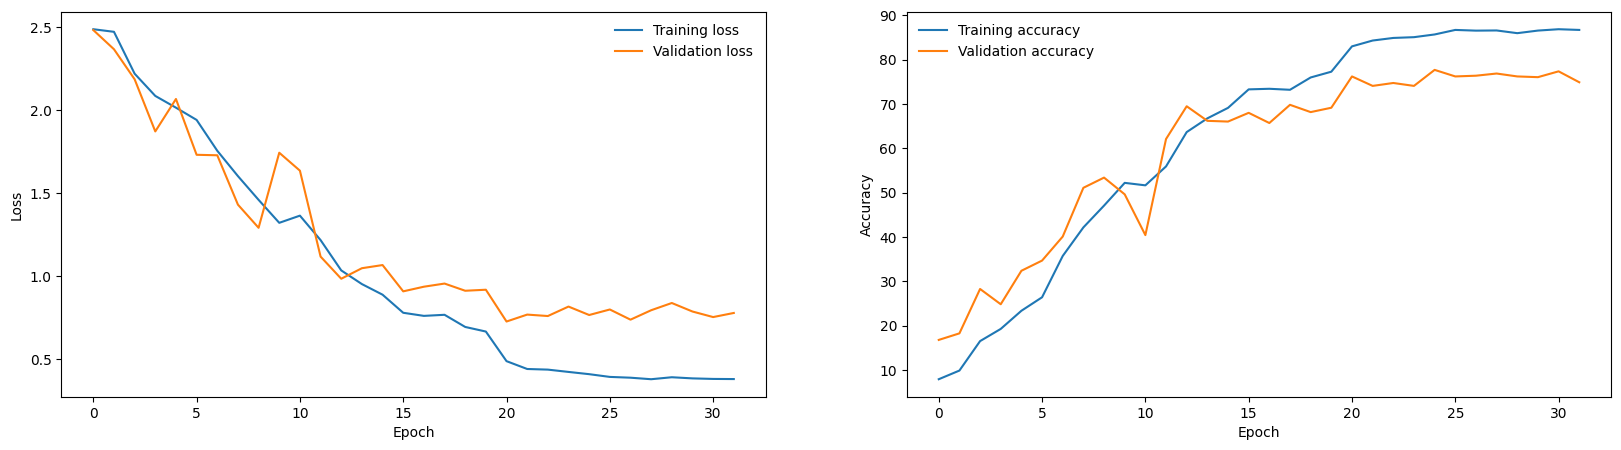

In [116]:
fig = plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training accuracy')
plt.plot(valid_accs, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy') 
plt.legend(frameon=False)
plt.show()

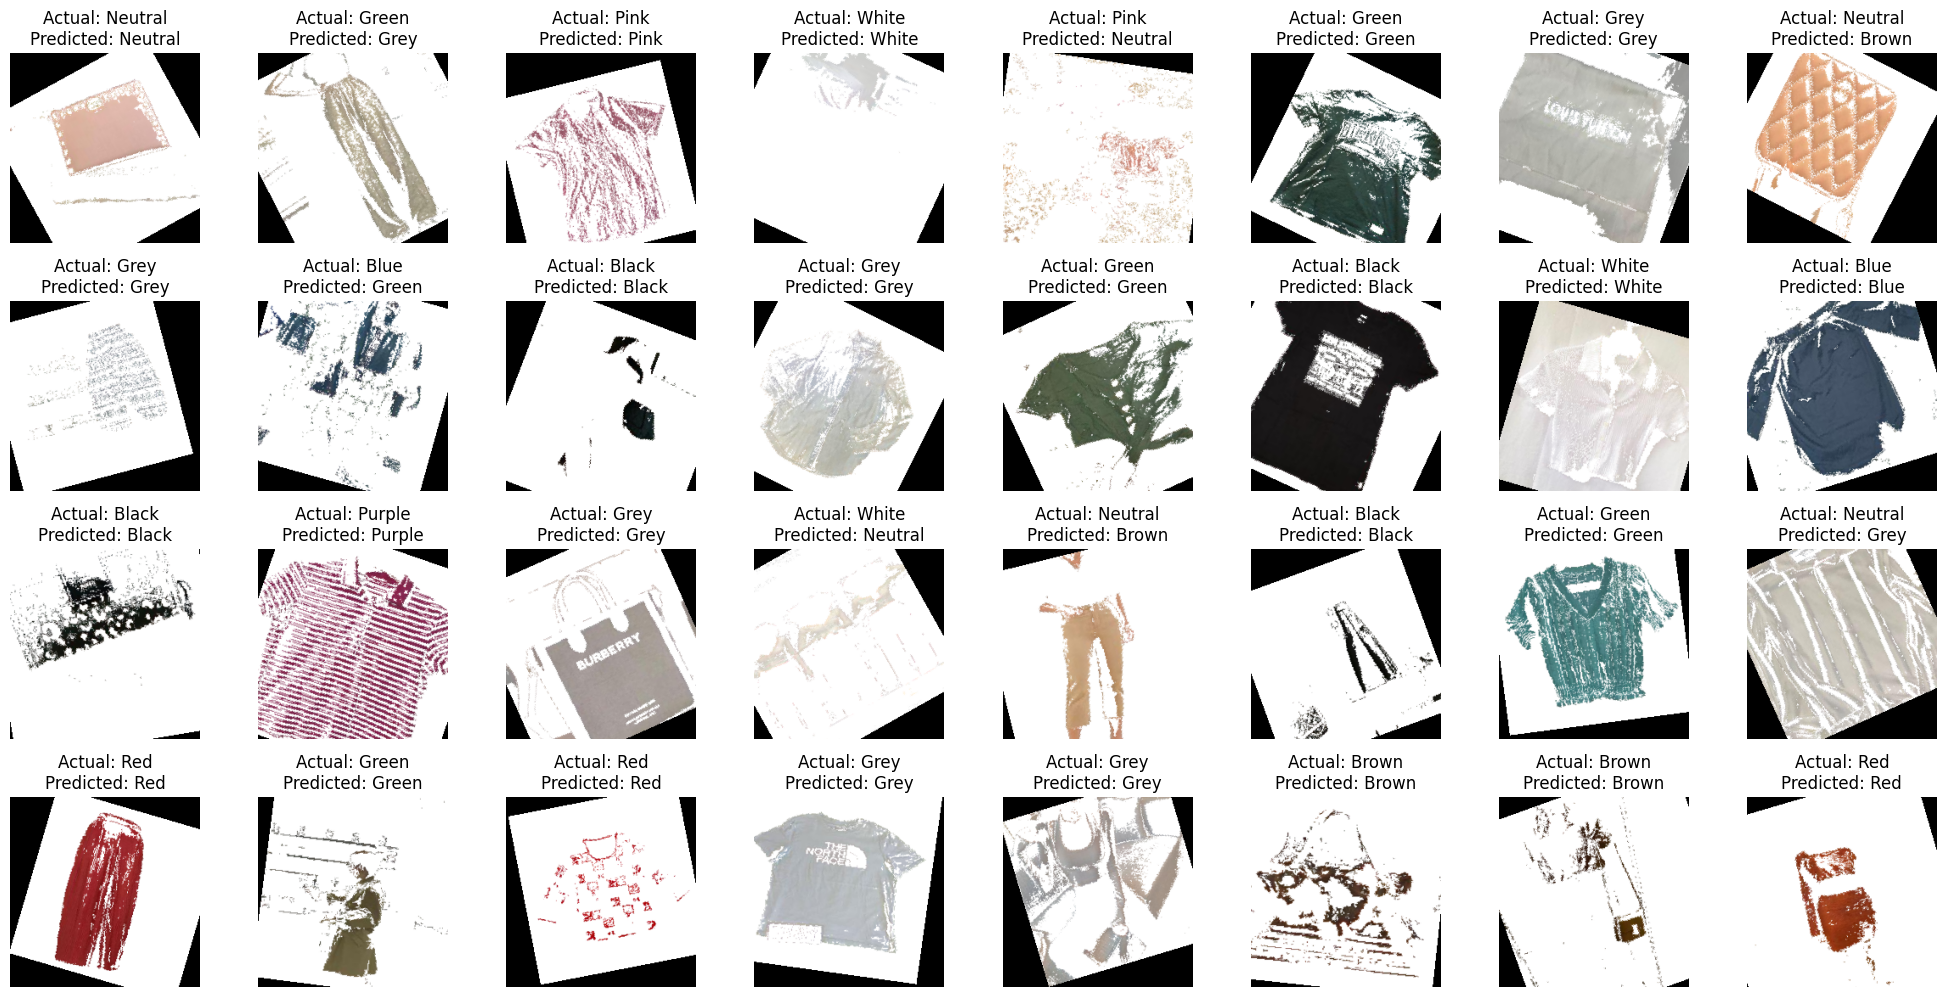

In [117]:
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)
fig = plt.figure(figsize=(20, 20))
for i in range(32):
    ax = plt.subplot(8, 8, i+1)
    ax.imshow(images[i].permute(1, 2, 0).cpu())
    ax.set_title("Actual: {}\nPredicted: {}".format(
        list(color_dict.keys())[list(color_dict.values()).index(labels[i].item())],
        list(color_dict.keys())[list(color_dict.values()).index(preds[i].item())]
    ))
    ax.axis('off')
plt.tight_layout()
plt.show()

In [118]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

model.to(device)
model.eval()
y_pred = []
y_true = []
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    output = model(images)
    _, preds = torch.max(output, 1)
    y_pred.extend(preds.tolist())
    y_true.extend(labels.tolist())
print("F1 Score: {:.6f}".format(f1_score(y_true, y_pred, average='weighted')))
print("Precision: {:.6f}".format(precision_score(y_true, y_pred, average='weighted')))
print("Recall: {:.6f}".format(recall_score(y_true, y_pred, average='weighted')))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

F1 Score: 0.725822
Precision: 0.736836
Recall: 0.724590
Confusion Matrix:
[[ 10   0   0   0   0   1   4   0   0   2   1   0]
 [  0  29   1   0   3   0   0   1   3   0   0   0]
 [  0   2  58   0   0   0   0   5  13   0   2   0]
 [  0   0   0  18   0   0   8   0   7   0   0   0]
 [  0   2   0   0   1   2   1   0   0   0   0   0]
 [  1   2   1   0   0  66   3   1   5   3   0   0]
 [  4   1   0   1   0  13  33   0   5   0   0   0]
 [  0   5   4   0   0   7   0 121   4   0   0   0]
 [  0   4   4   4   0   5   4   5  68   0   2   0]
 [  3   0   0   0   0   3   0   0   0  23   2   0]
 [  8   0   2   0   0   1   0   0   0   0  11   0]
 [  0   0   0   0   0   2   0   0   0   1   0   4]]


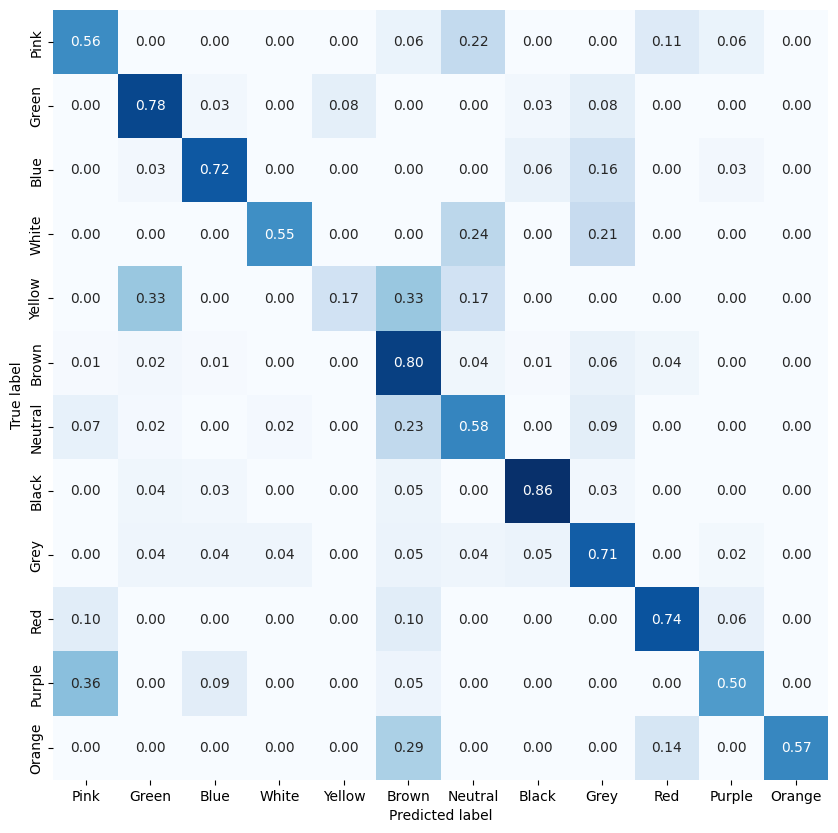

In [119]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, index=list(color_dict.keys()), columns=list(color_dict.keys()))
plt.figure(figsize=(10, 10))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='.2f', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [120]:
writer.close()